### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
import time
from itertools import groupby
from operator import itemgetter

from detection import DetectBeats
from rejection import BeatReject
from snr import snr as compute_snr

##### Settings

In [2]:
min_frame = 125 * 20
sensitivity = 100
zero_grad_tolerance = .75

snr_threshold = 6.5
F_S = 125
PARAMS = {"pre_filter_type": "filtfilt", "beat_algo_kwargs": {},
          "sample_rate": F_S, "peak_tol": 0.5, "beat_algo": "mdf",
          "filtfilt_params": {"order": 4, "lowpass": 10., "highpass": .5}}

### Helper Functions

In [3]:
def evaluate_beats(env):
    """ call beat detection/rejection
    """
    detector = DetectBeats(PARAMS)
    onsets = detector.get_beat_starts(env)
    if len(onsets) < 2:
#         error_message = "MCA scan incomplete! Insufficient data to generate results. Please re-run exam."
#         raise Exception(error_message)
        return list(zip(onsets, onsets[1:])), [0], [0]
    detected = list(zip(onsets, onsets[1:]))
    rejector = BeatReject(reject_methods=['cc', 'len'])
    rejected, accepted = rejector.reject_beats(env, detected)
    return detected, rejected, accepted

def gradient_analysis_frame_detect(data, sens=sensitivity, m_f=min_frame, start_inc=20, stop_inc=5):
    grad = pd.Series(np.gradient(data), data.index, name='slope')
    grad_band = np.where(np.abs(grad) < sens, True, False)
    
    i = 0
    clean_frames = []
    while (i + m_f) < len(grad_band):
        for j in range(i+m_f, len(grad_band), stop_inc):
            temp_grad = grad[i:j]
            if all(grad_band[i:j]):
                if j >= (len(grad_band) - stop_inc):
                    if len(temp_grad[temp_grad==0]) < (zero_grad_tolerance * len(temp_grad)):
                        clean_frames.append((i, j))
                    return clean_frames
                else:        
                    continue
            else:
                if (len(temp_grad) > m_f) and (len(temp_grad[temp_grad==0]) < (zero_grad_tolerance * len(temp_grad))):
                    clean_frames.append((i, j-stop_inc))
                    i = j
                else:
                    i = i + start_inc
                break
    return clean_frames

def snr_segment_detect(env, min_snr=snr_threshold, m_f=min_frame, start_inc=100, stop_inc=50):
    i = 0
    clean_frames = []
    while (i + m_f) < len(env):
        prev = {'accepted': [], 'snr': 0}
        for j in range(i+m_f, len(env), stop_inc):
            #print(i, j)
            temp_env = np.array(env[i:j])
            detected, rejected, accepted = evaluate_beats(temp_env)
            if (len(accepted) > 3) and ((snr:=compute_snr(temp_env, accepted)) > min_snr):
                prev['accepted'] = accepted
                prev['snr'] = snr
                if j >= (len(env) - stop_inc):
                    #print(f"clean segment({i}, {j}) identified with {len(accepted)} accepted beats. SNR = {snr}")
                    accepted_beats = [(x+i, y+i) for (x, y) in accepted]
                    clean_frames.extend(accepted_beats)

                    return clean_frames
                else:        
                    continue
            else:
                if prev['accepted'] and (len(temp_env) > m_f):
                    #print(f"SNR dropped below threshold, using last good SNR with {len(prev['accepted'])} accepted beats. SNR = {prev['snr']}")
                    accepted_beats = [(x+i, y+i) for (x, y) in prev['accepted']]
                    clean_frames.extend(accepted_beats)
                    i = j
                else:
                    i = i+start_inc
                break
    return clean_frames

def combine_consecutive_beats(beats):   
    segs = []
    i = 0
    while i < (len(beats) - 2):
        if beats[i][1] != beats[i+1][0]:
            segs.append(beats[i])
            i = i+1
        else:
            temp_seg = [beats[i][0], beats[i][1]]
            while (i < (len(beats) - 1)) and (beats[i][1] == beats[i+1][0]):
                i = i+1
            temp_seg[1] = beats[i][1]
            segs.append(tuple(temp_seg))
            i = i+1
    return segs

def snr_frame_detect(env):
    accepted_beats = snr_segment_detect(env)
    frames = combine_consecutive_beats(accepted_beats)
    return frames

def double_whammy(env):
    frames = gradient_analysis_frame_detect(env)
    print(f"Clean Frames identified: {len(frames)}")
    accepted_beats = []
    for f in frames:
        temp_env = np.array(env[f[0]:f[1]])
        detected, rejected, accepted = evaluate_beats(temp_env)
        if len(accepted) > 3:
            snr = compute_snr(list(temp_env), accepted)
            print(f"Accepted Beats in Segment: {len(accepted)}")
            if snr > snr_threshold:
                adjusted_beats = [(x+f[0], y+f[0]) for (x, y) in accepted]
                accepted_beats.extend(adjusted_beats)
    print(f"Total beats accepted: {len(accepted_beats)}")
    final_frames = combine_consecutive_beats(accepted_beats)
    return final_frames

def large_plot(data, title, x_label="Time (seconds)", y_label="Velocity (cm/s)", hlines=[]):
    f = plt.figure(figsize=(16, 8), dpi=80)
    plt.plot(data.index/125, data/10, c='dodgerblue')
    f.suptitle(title, fontsize=20)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=16)
    if len(hlines) > 0:
        plt.hlines(hlines, xmin=data.index[0] / 125, xmax=data.index[-1] / 125)
    plt.grid()
    
def large_highlight_plot(data, overlays, title, x_label="Time (seconds)", y_label="Velocity (cm/s)", hlines=[]):
    f = plt.figure(figsize=(16, 8), dpi=80)

    plt.plot(data.index/125, data/10, c='dodgerblue')
    for overlay in overlays:
        plt.plot(data.index[overlay[0] : overlay[1]] / 125, data[overlay[0] : overlay[1]] / 10, c='springgreen')
    
    f.suptitle(title, fontsize=20)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=16)
    if len(hlines) > 0:
        plt.hlines(hlines, xmin=data.index[0] / 125, xmax=data.index[-1] / 125)
    plt.grid()
        
def plot_segment(data, segs, seg_num, title, x_label="Time (seconds)", y_label="Velocity (cm/s)"):
    f = plt.figure(figsize=(16, 8), dpi=80)
    clean_seg = segs[seg_num]
    plt.plot(data.index[clean_seg[0] : clean_seg[1]] / 125, data[clean_seg[0] : clean_seg[1]] / 10, c='dodgerblue')
    
    f.suptitle(title, fontsize=20)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=16)
    plt.grid()
    
def gen_subplots(data_dict, frame_detection):
    fig, axes = plt.subplots(len(data_dict), 2, figsize=(16,20))

    for i, [title, dats] in enumerate(data_dict.items()):
        for j, dat in enumerate(dats):
            print(i, j, title)
            frames = frame_detection(dat.posVelocity)
            #print(frames)
            axes[i][j].plot(dat.index / 125, dat.posVelocity / 10, c='dodgerblue')
            side = 'Right' if j==0 else 'Left'
            axes[i][j].title.set_text(f'{title} {side}')
            for overlay in frames:
                axes[i][j].plot(dat.index[overlay[0] : overlay[1]] / 125, dat.posVelocity[overlay[0] : overlay[1]] / 10, c='springgreen')
            
            total_segments = len(frames)
            axes[i][j].title.set_text(f'{title} {side}: {total_segments} Clean Segments')
            axes[i][j].set_xlabel('Time (seconds)')
            axes[i][j].set_ylabel('Velocity (cm/s)')
    
    fig.subplots_adjust(hspace=0.5)

def gen_dual_subplots(data_dict, frame_detection):
    fig, axes = plt.subplots(len(dat_boi),2, figsize=(15,18))

    for i, [title, dats] in enumerate(dat_boi.items()):
        for j, dat in enumerate(dats):
            env = dat     
            frames_dual = [frame_detection(env.posVelocity), 
                           frame_detection(env.negVelocity)]

            axes[i][j].plot(env.index / 125, env.posVelocity / 10, c='dodgerblue')
            for overlay in frames_dual[0]:
                axes[i][j].plot(env.index[overlay[0] : overlay[1]] / 125, env.posVelocity[overlay[0] : overlay[1]] / 10, c='springgreen')

            axes[i][j].plot(env.index / 125, env.negVelocity / 10, c='dodgerblue')
            for overlay in frames_dual[1]:
                axes[i][j].plot(env.index[overlay[0] : overlay[1]] / 125, env.negVelocity[overlay[0] : overlay[1]] / 10, c='springgreen')        

            side = 'Right' if j==0 else 'Left'
            total_segments = len(frames_dual[0]) + len(frames_dual[1])
            axes[i][j].title.set_text(f'{title} {side}: {total_segments} Clean Segments')
            axes[i][j].set_xlabel('Time (seconds)')
            axes[i][j].set_ylabel('Velocity (cm/s)')

    fig.subplots_adjust(hspace=0.3)
    

    


### Load Data

In [4]:
mon_r_env = pd.read_csv('envelopes/142-Channel1_env.csv', usecols = ['posVelocity', 'negVelocity'])

mon_l_env = pd.read_csv('envelopes/142-Channel2_env.csv', usecols = ['posVelocity', 'negVelocity'])

cr3_r_env = pd.read_csv('envelopes/711-Channel1_env.csv', usecols = ['posVelocity', 'negVelocity'])

cr3_l_env = pd.read_csv('envelopes/711-Channel2_env.csv', usecols = ['posVelocity', 'negVelocity'])

mcalock_r_env = pd.read_csv('envelopes/712-Channel1_env.csv', usecols = ['posVelocity', 'negVelocity'])

mcalock_l_env = pd.read_csv('envelopes/712-Channel2_env.csv', usecols = ['posVelocity', 'negVelocity'])

mca_r_env = pd.read_csv('data/107-Channel1.csv', usecols = ['posVelocity', 'negVelocity'])

mca_l_env = pd.read_csv('data/107-Channel2.csv', usecols = ['posVelocity', 'negVelocity'])

dat_boi = {
    'Monitoring': [mon_r_env, mon_l_env],
    'Clinical Release 3': [cr3_r_env, cr3_l_env],
    'MCA Lock': [mcalock_r_env, mcalock_l_env],
    'MCA Scan': [mca_r_env, mca_l_env]
}

env = mca_r_env

In [31]:
env

,posVelocity,negVelocity
0,2153,-914
1,2153,-914
2,2153,-914
3,2153,-914
4,2153,-914
...,...,...
76619,493,0
76620,493,0
76621,493,0
76622,493,0


### Present Raw Data

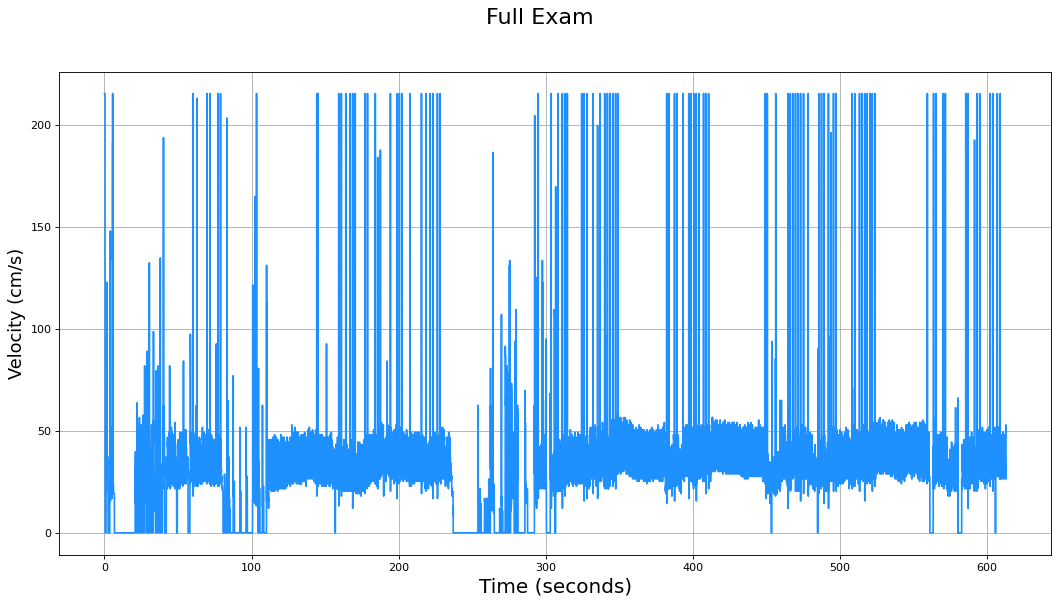

In [5]:
large_plot(env.posVelocity, 'Full Exam')

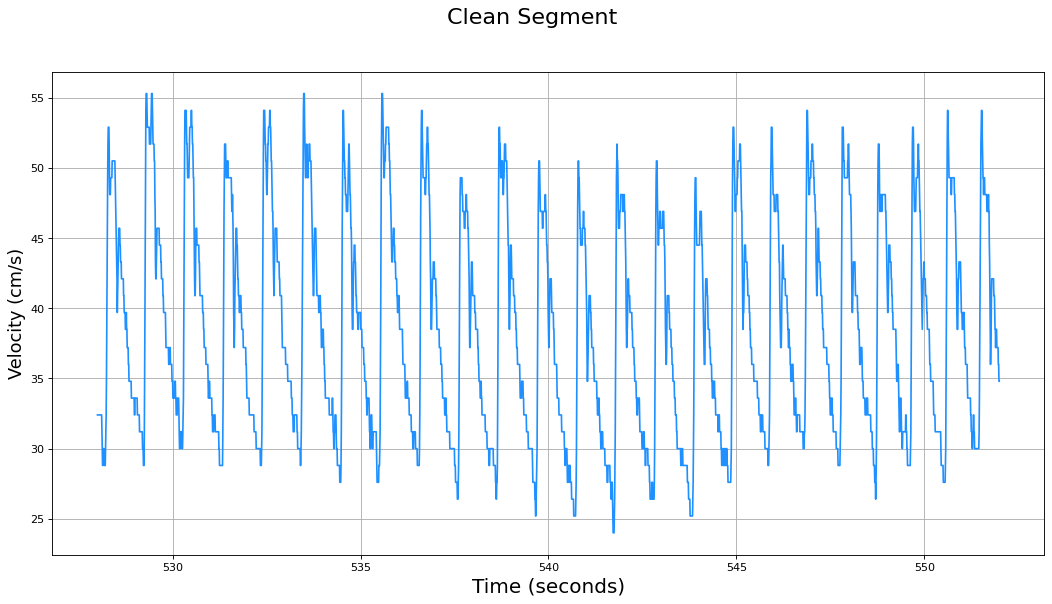

In [6]:
large_plot(env.posVelocity[66000:69000], 'Clean Segment')

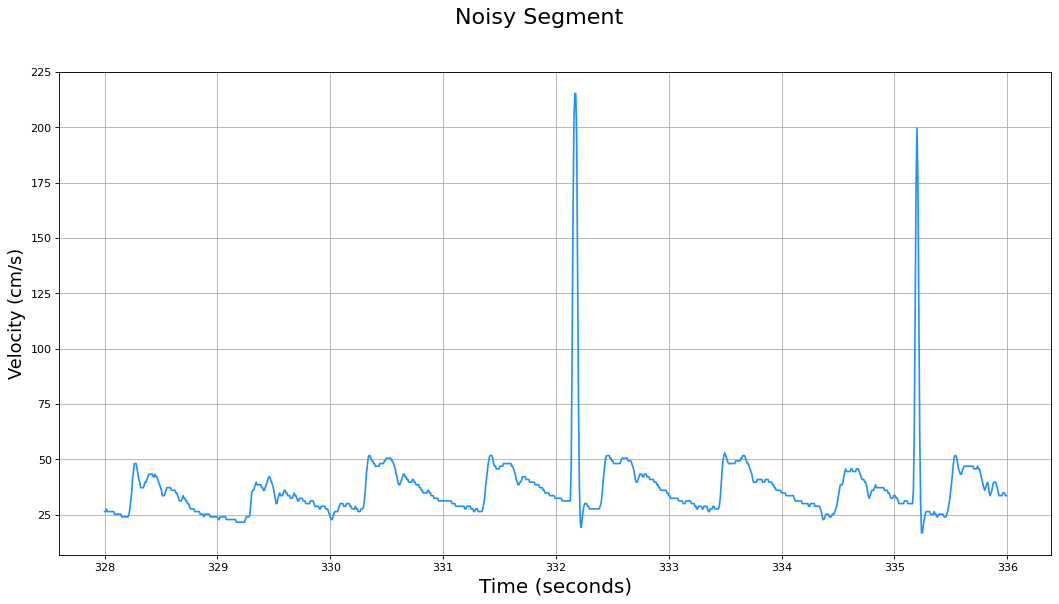

In [7]:
large_plot(env.posVelocity[41000:42000], 'Noisy Segment')

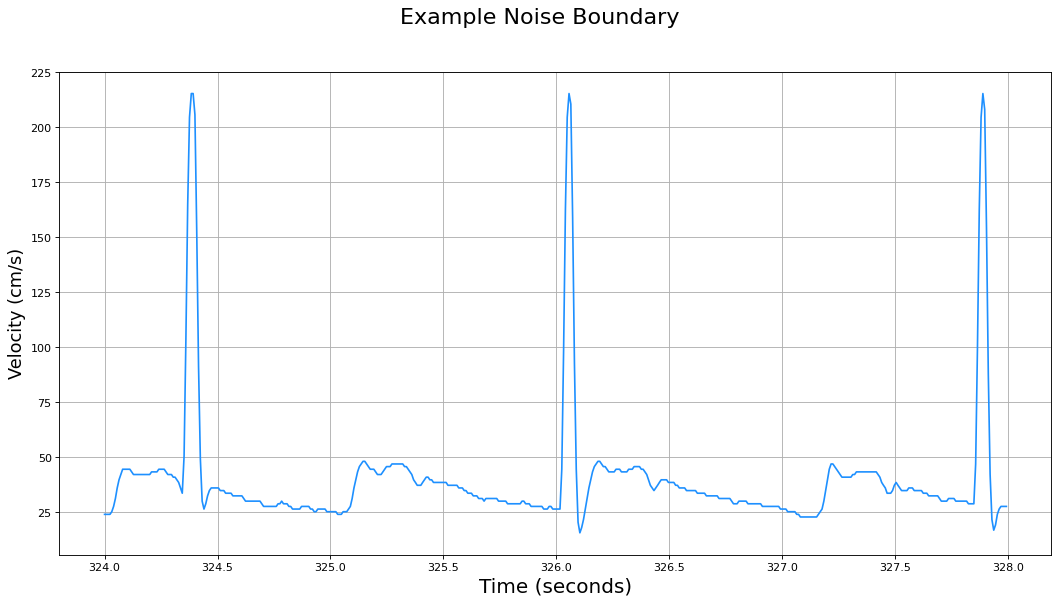

In [8]:
large_plot(env.posVelocity[40500:41000], 'Example Noise Boundary')

## Detect Clean Segments

### Calculate Gradient

In [9]:
env = mca_r_env
print(env.shape)

(76624, 2)


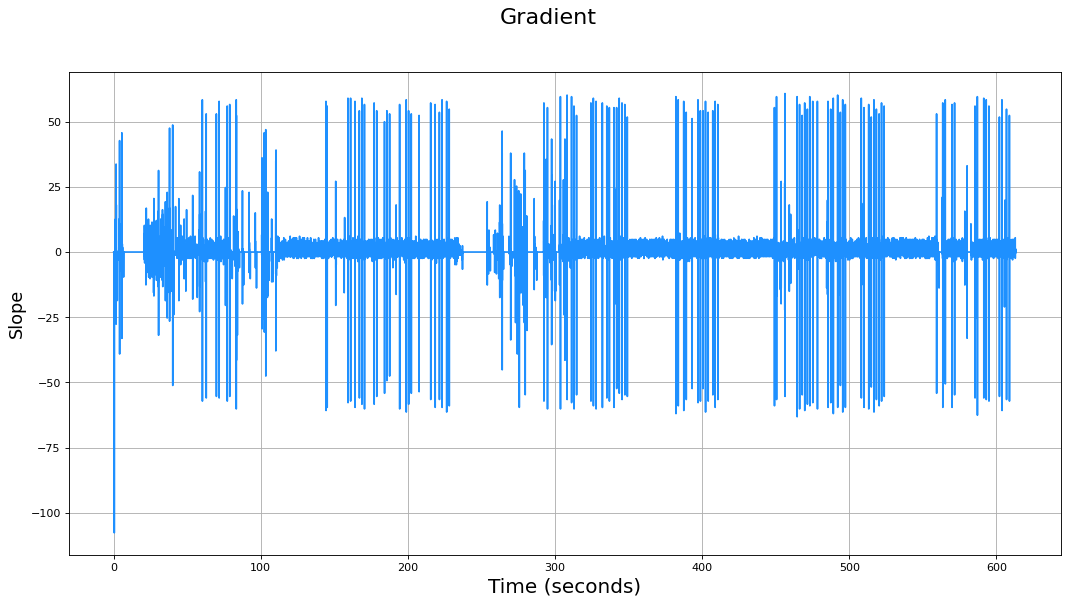

In [10]:
gradient = pd.Series(np.gradient(env.posVelocity), env.index, name='slope')

large_plot(gradient, 'Gradient', y_label='Slope')

### "Band-Pass Filter" on Gradient

In [11]:
%%time

frames = gradient_analysis_frame_detect(env.posVelocity)
frames

CPU times: user 396 ms, sys: 702 µs, total: 396 ms
Wall time: 393 ms


[(13820, 18035), (43660, 47765), (51350, 56135), (65480, 69915)]

In [12]:
for f in frames:
    print((f[1] - f[0])/125)

33.72
32.84
38.28
35.48


In [13]:
for f in frames:
    temp_env = np.array(env[f[0]:f[1]].posVelocity)
    detected, rejected, accepted = evaluate_beats(temp_env)
    print(compute_snr(list(temp_env), accepted))

10.196678027690599
12.738161569125861
13.280785311933414
11.582239350965256


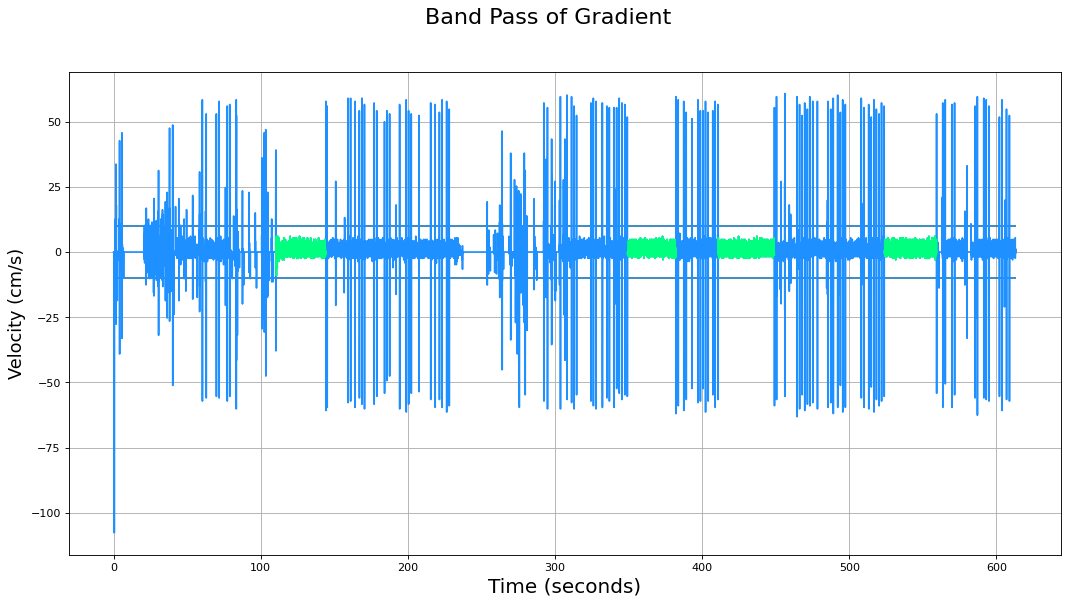

In [14]:
large_highlight_plot(gradient, frames, 'Band Pass of Gradient', hlines=[sensitivity/10,-sensitivity/10])

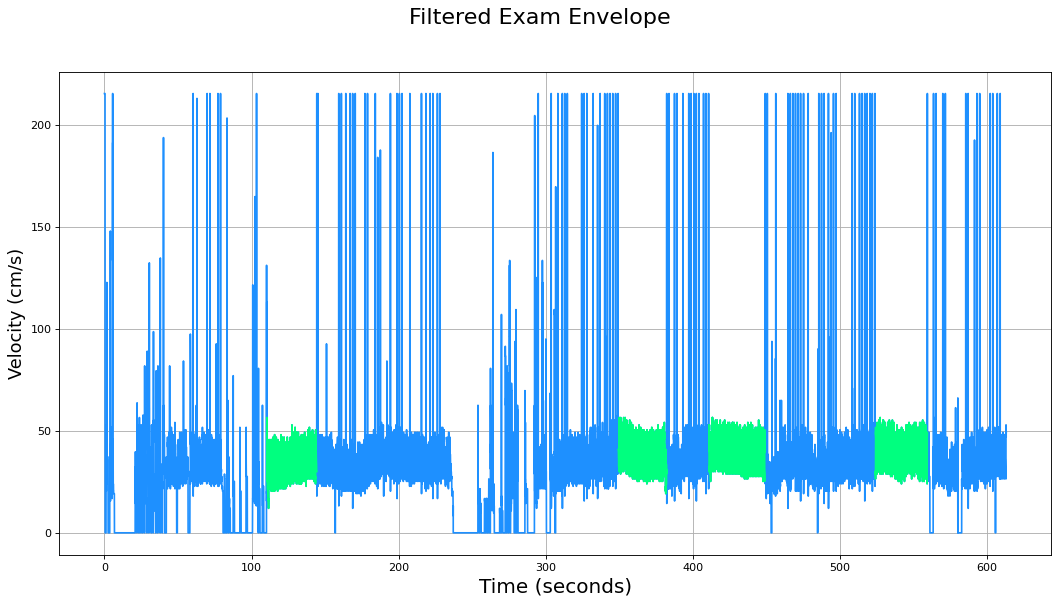

In [15]:
large_highlight_plot(env.posVelocity, frames, 'Filtered Exam Envelope')

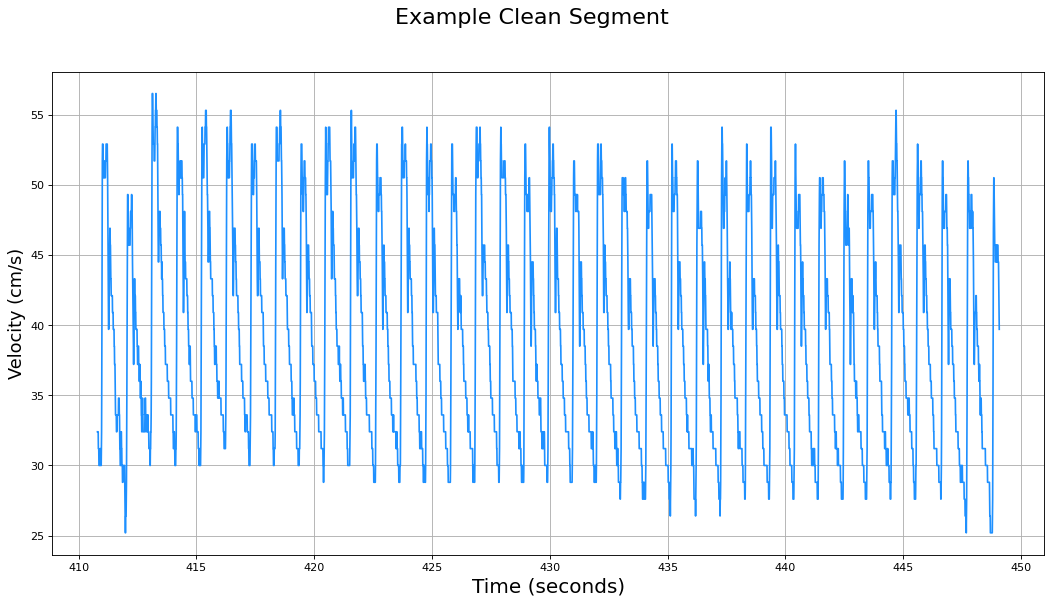

In [16]:
plot_segment(env.posVelocity, frames, -2, 'Example Clean Segment')

In [17]:
%%time

accepted_beats = snr_segment_detect(env.posVelocity)
frames = combine_consecutive_beats(accepted_beats)

frames

CPU times: user 2min 7s, sys: 77.9 ms, total: 2min 8s
Wall time: 2min 7s


[(6259, 6520),
 (6778, 7031),
 (7426, 7526),
 (8313, 8715),
 (14050, 14583),
 (14718, 17938),
 (18340, 18611),
 (19007, 19139),
 (22462, 23002),
 (23525, 23659),
 (24474, 24606),
 (39448, 39976),
 (40105, 40500),
 (42497, 43182),
 (43422, 43632),
 (47764, 47958),
 (48427, 48638),
 (49839, 50501),
 (50894, 51094),
 (58060, 59137),
 (60686, 61132),
 (61934, 62156),
 (64144, 64588),
 (64795, 65457),
 (70435, 70648),
 (71222, 71437)]

In [18]:
for f in frames:
    print((f[1] - f[0])/125)

2.088
2.024
0.8
3.216
4.264
25.76
2.168
1.056
4.32
1.072
1.056
4.224
3.16
5.48
1.68
1.552
1.688
5.296
1.6
8.616
3.568
1.776
3.552
5.296
1.704
1.72


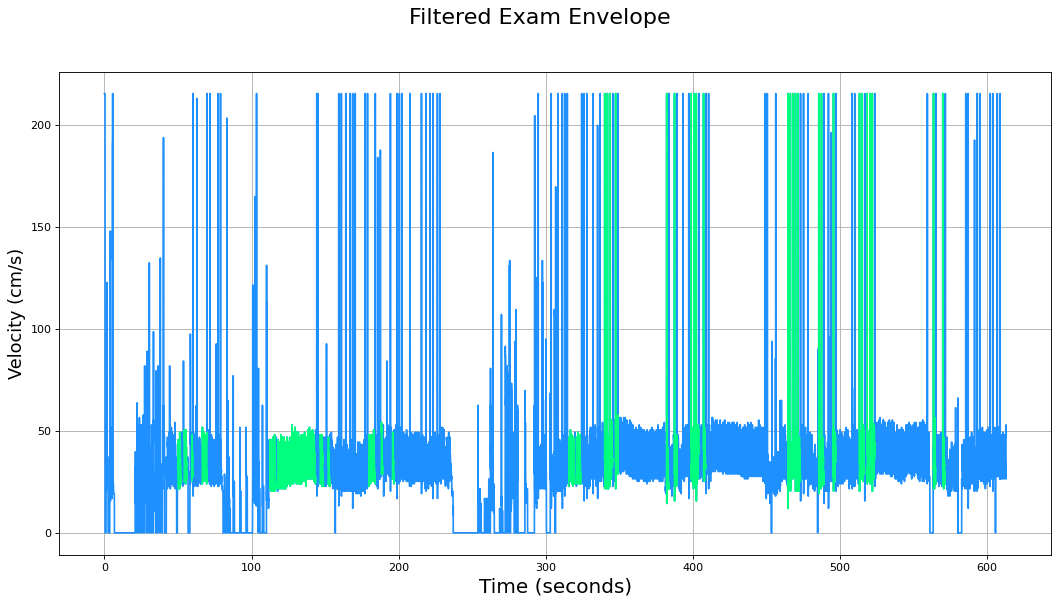

In [19]:
large_highlight_plot(env.posVelocity, frames, 'Filtered Exam Envelope')

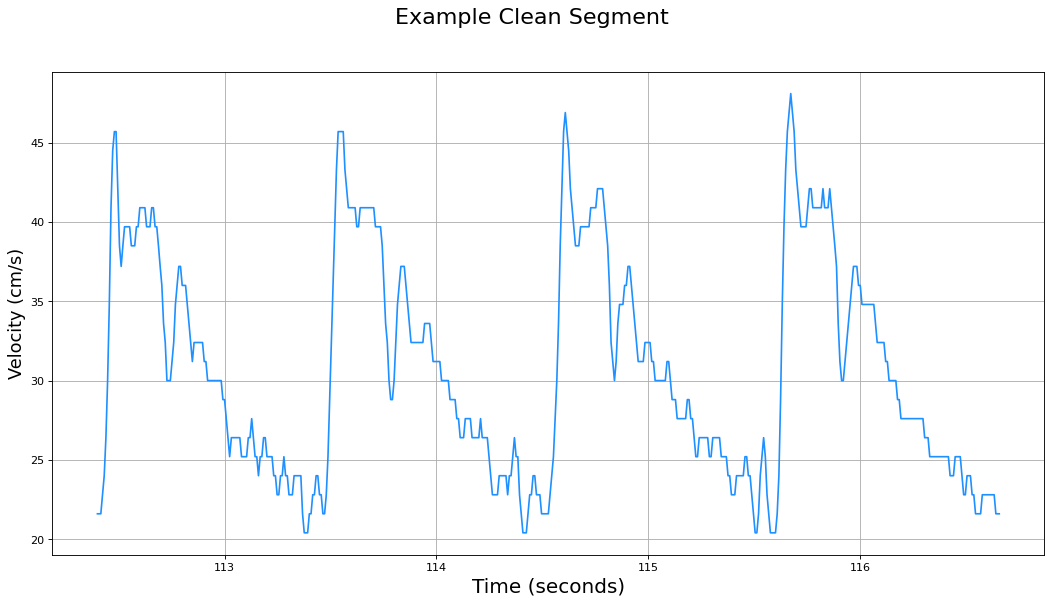

In [20]:
plot_segment(env.posVelocity, frames, 4, 'Example Clean Segment')

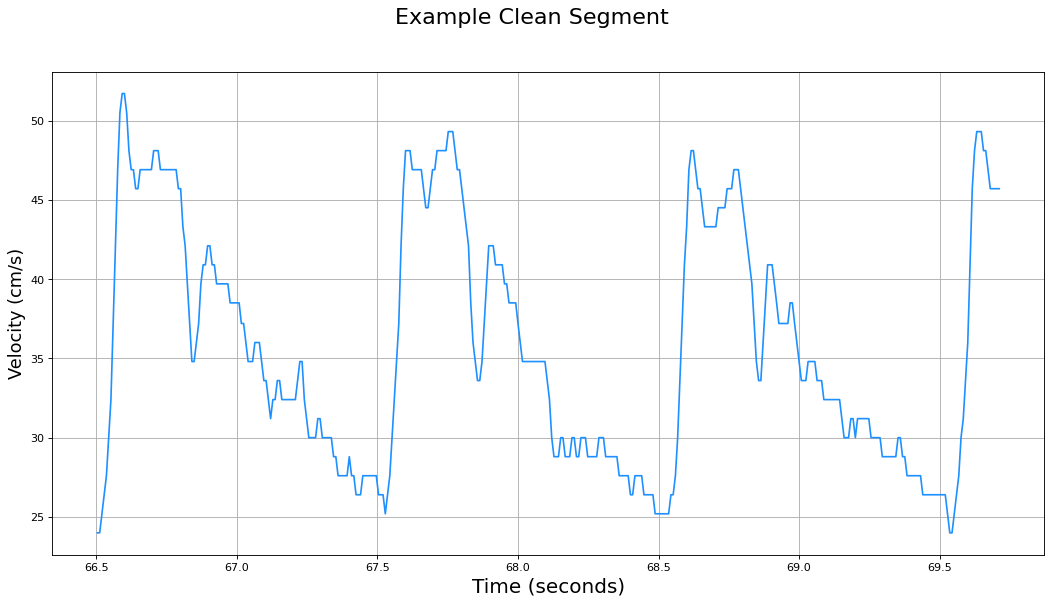

In [21]:
plot_segment(env.posVelocity, frames, 3, 'Example Clean Segment')

In [22]:
%%time

frames = double_whammy(env.posVelocity)
frames

Clean Frames identified: 4
Accepted Beats in Segment: 24
Accepted Beats in Segment: 25
Accepted Beats in Segment: 33
Accepted Beats in Segment: 34
Total beats accepted: 116
CPU times: user 566 ms, sys: 94 µs, total: 566 ms
Wall time: 560 ms


[(14718, 17938),
 (43853, 43982),
 (44230, 45951),
 (46089, 47559),
 (51630, 55688),
 (55823, 56094),
 (65513, 69774)]

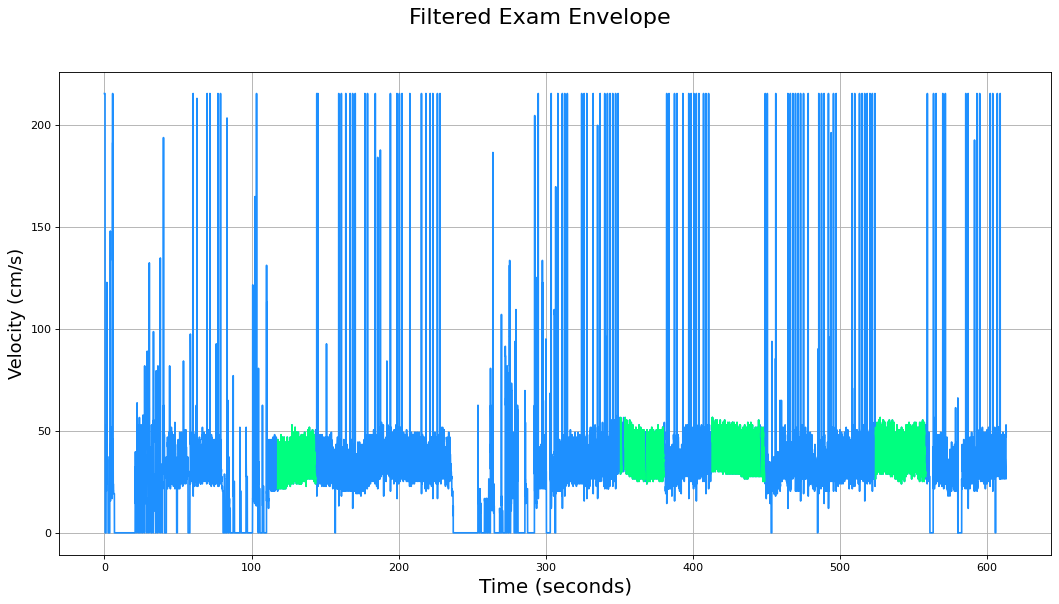

In [23]:
large_highlight_plot(env.posVelocity, frames, 'Filtered Exam Envelope')

## Comparison

0 0 Monitoring
0 1 Monitoring
1 0 Clinical Release 3
1 1 Clinical Release 3
2 0 MCA Lock
2 1 MCA Lock
3 0 MCA Scan
3 1 MCA Scan


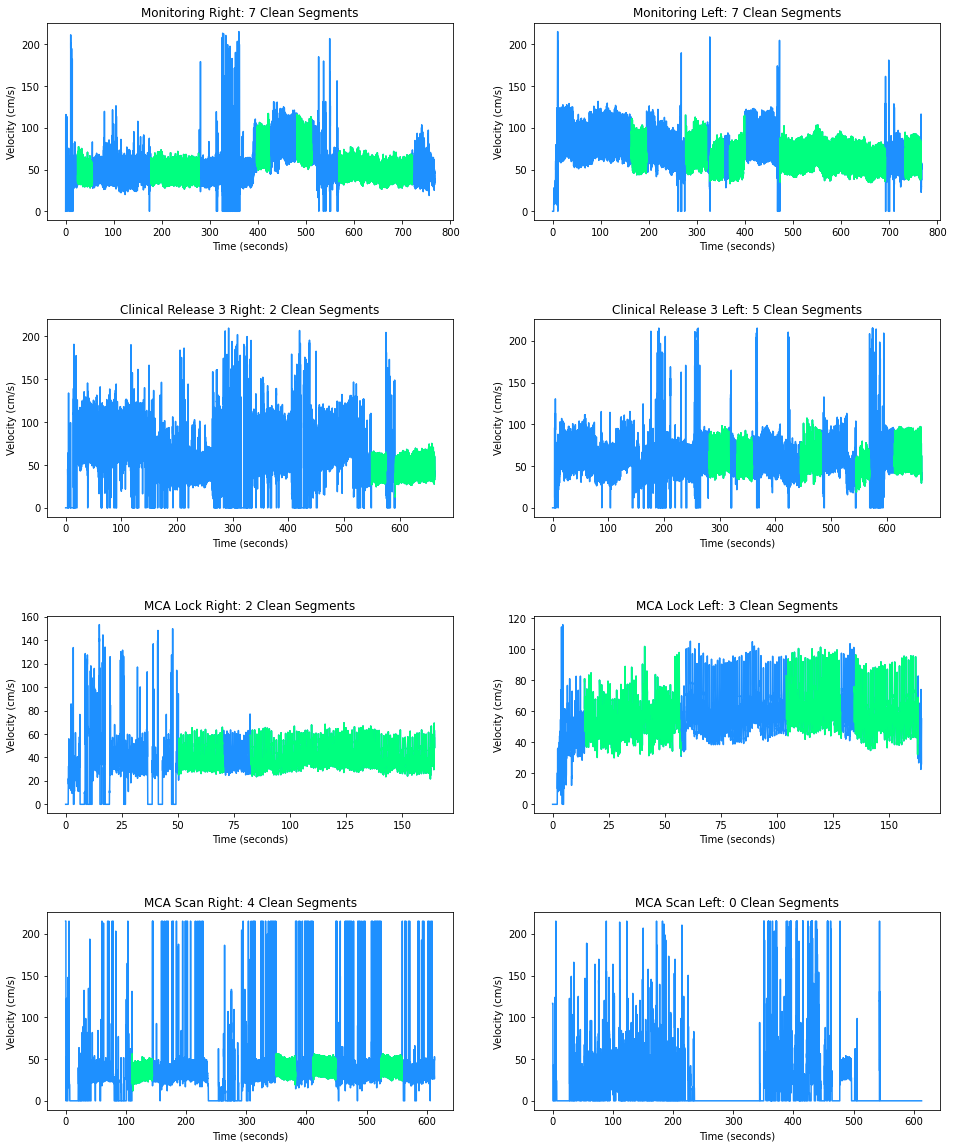

In [24]:
gen_subplots(dat_boi, gradient_analysis_frame_detect)

0 0 Monitoring
0 1 Monitoring
1 0 Clinical Release 3
1 1 Clinical Release 3
2 0 MCA Lock
2 1 MCA Lock
3 0 MCA Scan
3 1 MCA Scan


/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


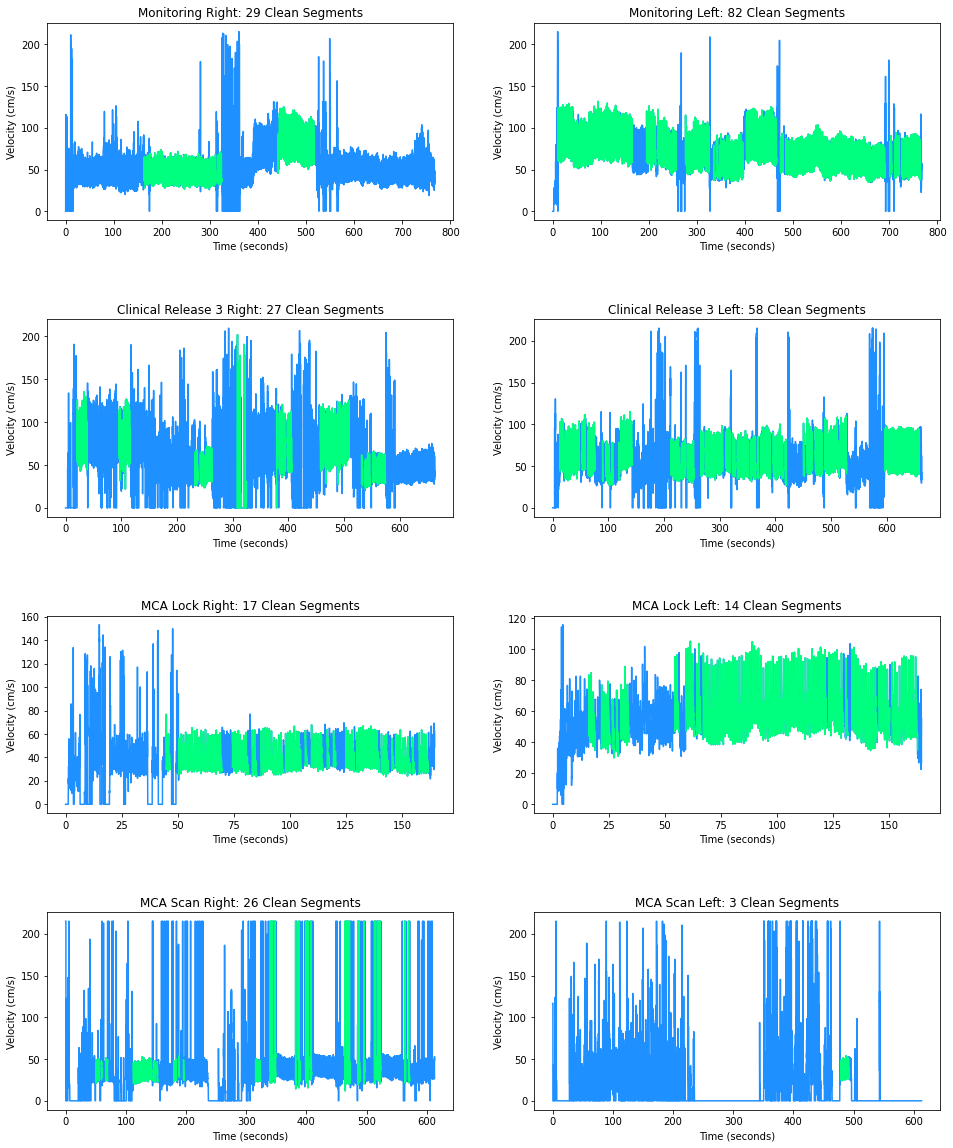

In [25]:
gen_subplots(dat_boi, snr_frame_detect)

0 0 Monitoring
Clean Frames identified: 7
Accepted Beats in Segment: 36
Accepted Beats in Segment: 70
Accepted Beats in Segment: 46
Accepted Beats in Segment: 26
Accepted Beats in Segment: 37
Accepted Beats in Segment: 58
Accepted Beats in Segment: 118
Total beats accepted: 237
0 1 Monitoring
Clean Frames identified: 7
Accepted Beats in Segment: 33
Accepted Beats in Segment: 45
Accepted Beats in Segment: 33
Accepted Beats in Segment: 28
Accepted Beats in Segment: 85
Accepted Beats in Segment: 161
Accepted Beats in Segment: 30
Total beats accepted: 254
1 0 Clinical Release 3
Clean Frames identified: 2
Accepted Beats in Segment: 19
Accepted Beats in Segment: 71
Total beats accepted: 90
1 1 Clinical Release 3
Clean Frames identified: 5
Accepted Beats in Segment: 29
Accepted Beats in Segment: 21
Accepted Beats in Segment: 33
Accepted Beats in Segment: 23
Accepted Beats in Segment: 49
Total beats accepted: 99
2 0 MCA Lock
Clean Frames identified: 2
Accepted Beats in Segment: 19
Accepted Bea

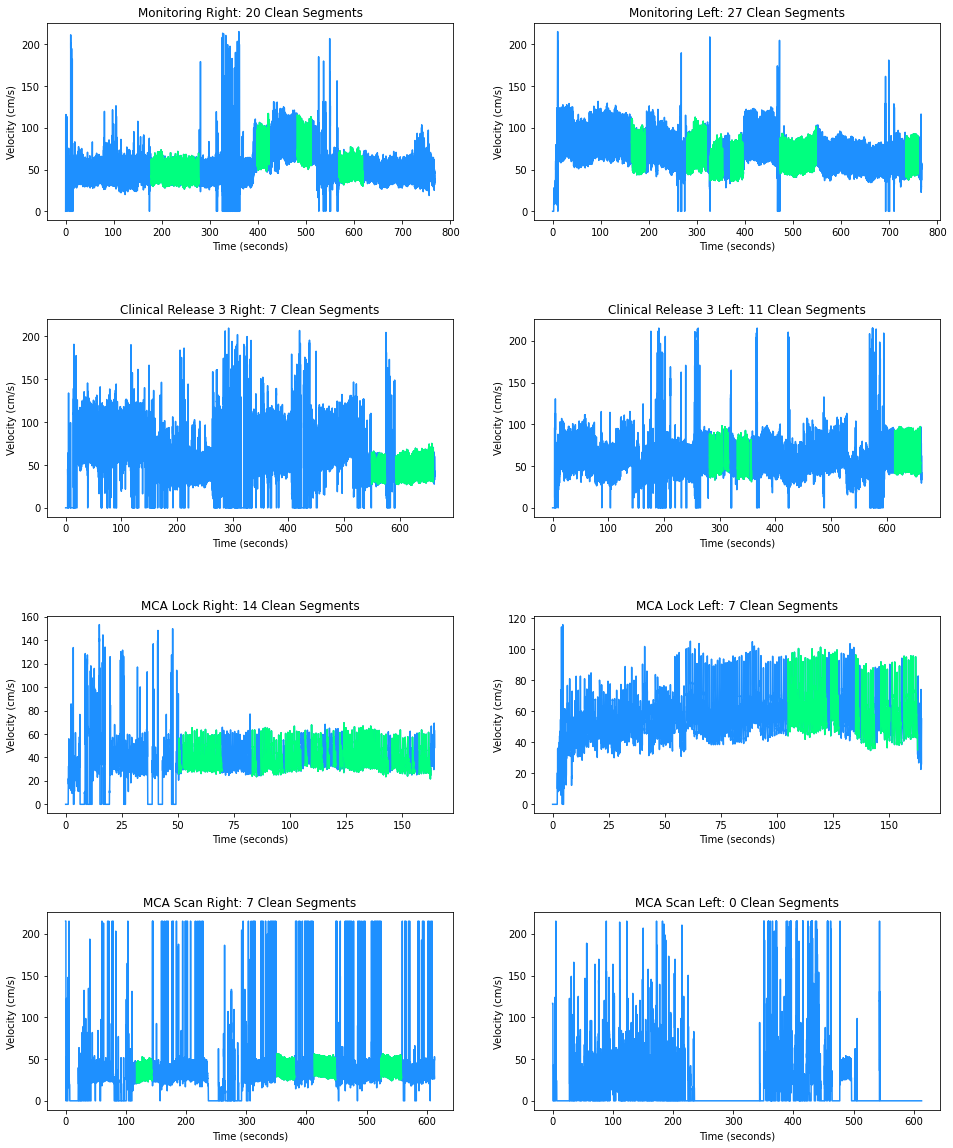

In [26]:
gen_subplots(dat_boi, double_whammy)

# Bi-Directional Analysis

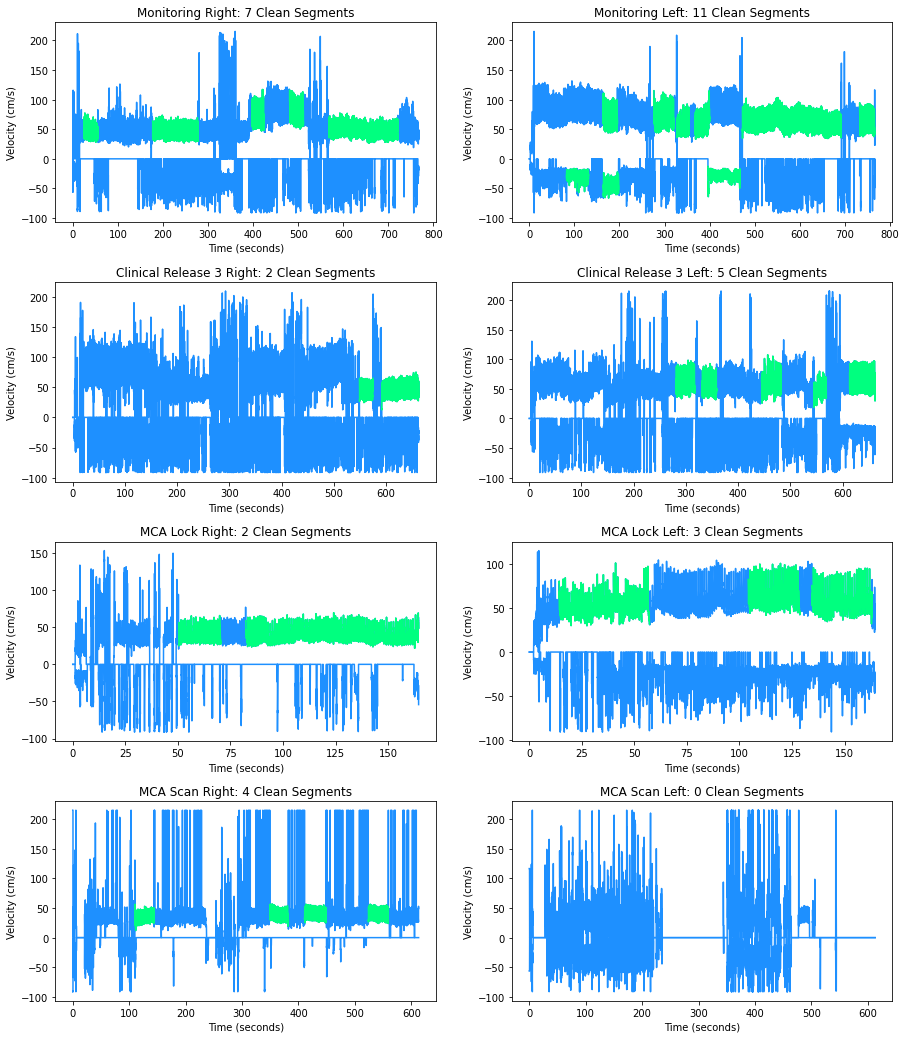

In [27]:
gen_dual_subplots(dat_boi, gradient_analysis_frame_detect)

/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nova_aditya/mypy38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

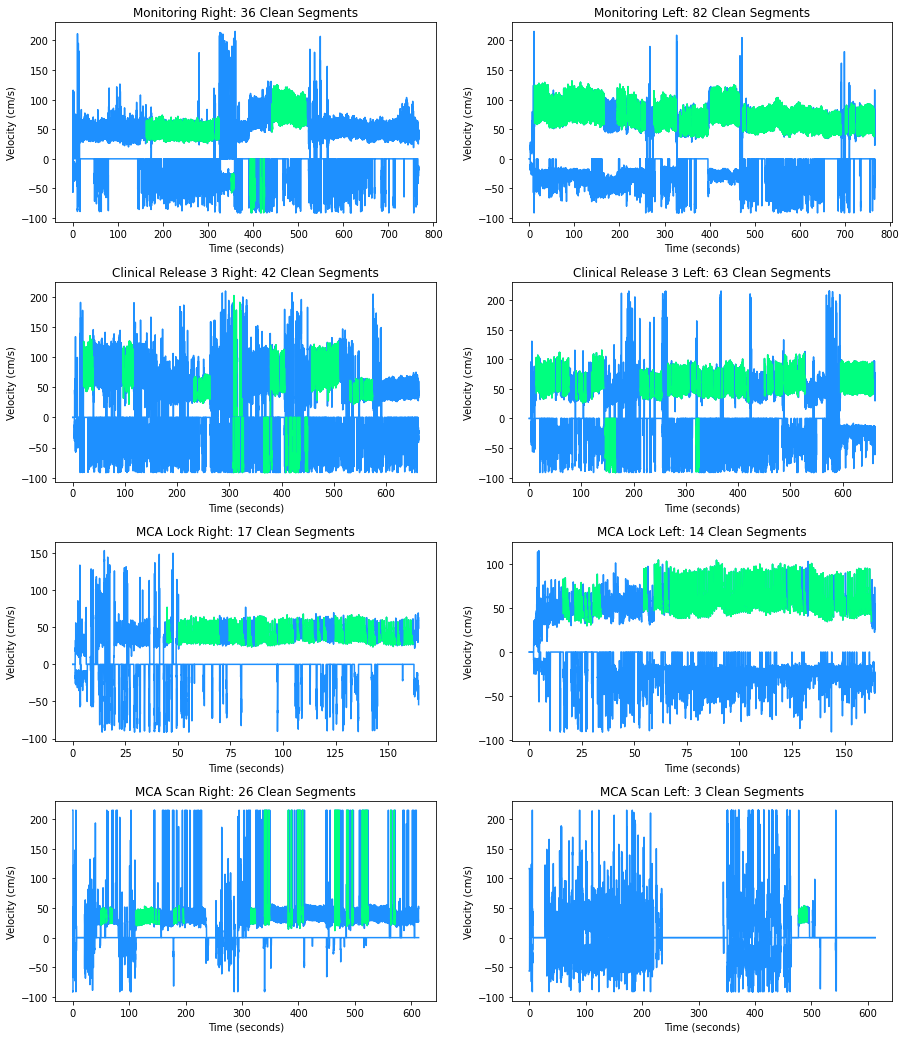

In [28]:
gen_dual_subplots(dat_boi, snr_frame_detect)

Clean Frames identified: 7
Accepted Beats in Segment: 36
Accepted Beats in Segment: 70
Accepted Beats in Segment: 46
Accepted Beats in Segment: 26
Accepted Beats in Segment: 37
Accepted Beats in Segment: 58
Accepted Beats in Segment: 118
Total beats accepted: 237
Clean Frames identified: 0
Total beats accepted: 0
Clean Frames identified: 7
Accepted Beats in Segment: 33
Accepted Beats in Segment: 45
Accepted Beats in Segment: 33
Accepted Beats in Segment: 28
Accepted Beats in Segment: 85
Accepted Beats in Segment: 161
Accepted Beats in Segment: 30
Total beats accepted: 254
Clean Frames identified: 4
Accepted Beats in Segment: 48
Accepted Beats in Segment: 38
Accepted Beats in Segment: 79
Accepted Beats in Segment: 138
Total beats accepted: 0
Clean Frames identified: 2
Accepted Beats in Segment: 19
Accepted Beats in Segment: 71
Total beats accepted: 90
Clean Frames identified: 0
Total beats accepted: 0
Clean Frames identified: 5
Accepted Beats in Segment: 29
Accepted Beats in Segment: 21

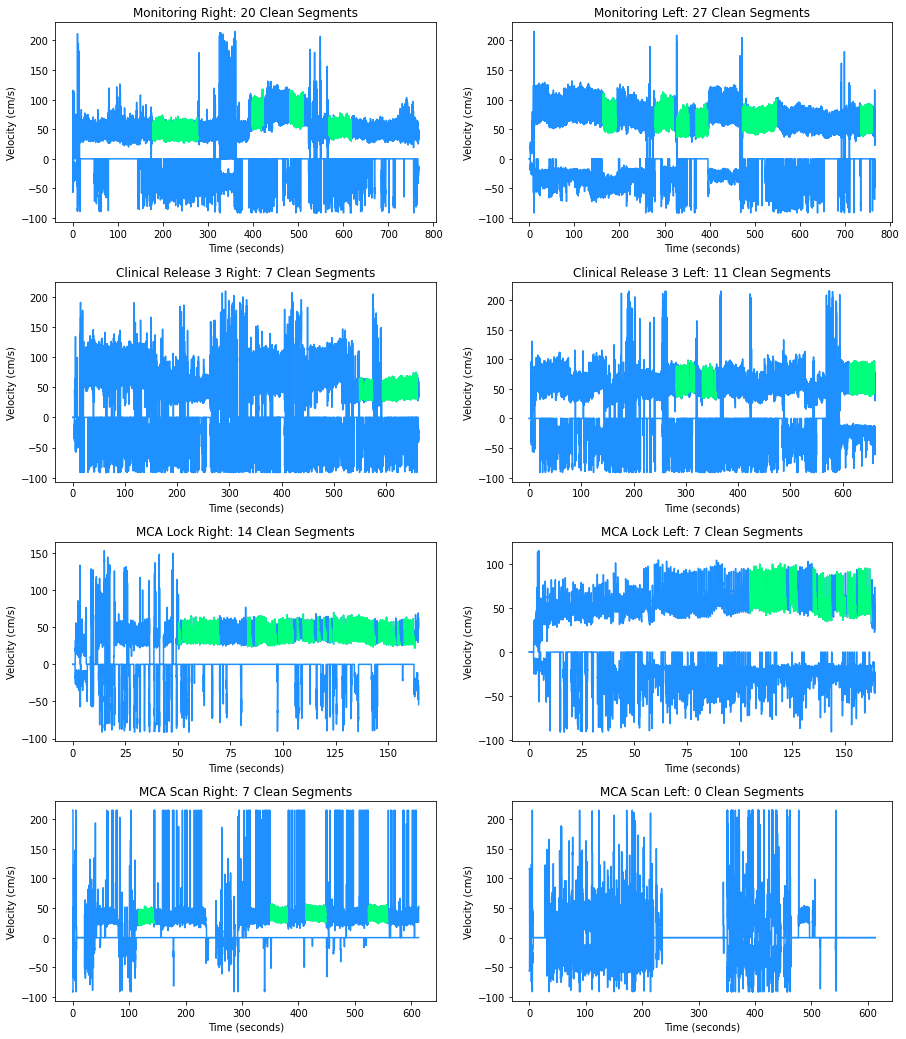

In [29]:
gen_dual_subplots(dat_boi, double_whammy)

In [30]:
stop_here()

NameError: name 'stop_here' is not defined

## Exploratory Optimizations Below

In [ ]:
def snr_frame_detect(env, min_snr=snr_threshold, m_f=min_frame):
    
    i = 0
    clean_frames = []
    while i < len(env):
        print(i)
        for j in range(i+m_f, len(env)):
            print(i, j)
            temp_env = env[i:j]
            if snr(temp_env, [(i, j)]) > 200:
                print('nice')
                if j == (len(env) - 1):
                    print(i, j)
                    clean_frames.append((i, j-1))
                    return clean_frames
                else:        
                    continue
            else:
                if len(temp_env) > m_f:
                    print(i, j)
                    clean_frames.append((i, j-1))
                    i = j
                else:
                    i = i + 1
                break
    return clean_frames

In [ ]:
env = mon_l_env.posVelocity


frames = snr_frame_detect(env)
frames

In [ ]:
def fast_frame_detect(grad, sens=sensitivity, m_f=min_frame):
    start_idxs = []
    
    i = 0
    while i < (len(grad) - m_f):
        seg = []
#         if i % 10000 == 0:
#             print(grad.index[i], (grad.index[i] + m_f))

        frame = grad[grad.index[i] : (grad.index[i] + m_f)]

        if len(frame[(frame > sens) | (frame < -sens)]) > 0:
            continue
        elif len(frame[frame == 0]) > (zero_grad_tolerance * len(frame)):
            continue
        else:
            seg[0] == grad.index[i]
            for j in range(i, (len(grad) - m_f)):
                if ((grad[j] < sens) and (grad[j] > -sens)):
                    continue
                else:
                    seg[1] = grad.index[j]
                    start_idxs.append(seg)
                    i = j
                    break
            
    return start_idxs
